In [1]:
import re
import copy
import pandas as pd
import numpy as np

## Fingerprints into single strings

In [3]:
fingerprints_file = "valid_data/drug_fingerprints.txt"
drug_names_file = 'valid_data/drugs_names.txt'

In [4]:
col_names      = ["chemical_name"]
drugs_names_df = pd.read_csv(drug_names_file, names=col_names)

In [5]:
drugs_names = list()
for i in range(len(drugs_names_df)):
    name = drugs_names_df["chemical_name"][i]
    drugs_names.append(name)

In [6]:
drugs_fingerprints_dict = {}
for i in range(len(drugs_names)):
    drugs_fingerprints_dict[drugs_names[i]] = [""] * 1024

In [7]:
def get_fingerprints(file_handle,drugs_fingerprints_dict, drugs_list):
    with open(file_handle) as fh:
        j=0
        content = fh.readlines()
        content = [x.strip() for x in content]
        for line in content:
            result = re.split(r'[,\t]\s*',line)
            drug_name = result[0]
            if drug_name in drugs_list:
                j=j+1
                for i in range(1,1025):
                    str1 = str(result[i])
                    drugs_fingerprints_dict[drug_name][i-1] = str1[0]
    fh.close()
    print(j)

In [8]:
get_fingerprints(fingerprints_file,drugs_fingerprints_dict, drugs_names)

41464


In [9]:
for i in range(len(drugs_names)):
    list1 = drugs_fingerprints_dict[drugs_names[i]]
    str1 = ''.join(list1)
    drugs_fingerprints_dict[drugs_names[i]] = str1

In [11]:
with open('fingerprints_strings.txt', 'w') as f:
    for key, value in drugs_fingerprints_dict.items():
        f.write(key)
        f.write(',')
        f.write(value)
        f.write('\n')

## Calculate similarity

In [2]:
fingerprints_file_1 = "sim_test/fingerprints_sample1.csv"
fingerprints_file_2 = "sim_test/fingerprints_sample2.csv"
drug_names_file_s   = "sim_test/name_sample.csv"

In [3]:
col_names       = ["chemical_name"]
drugs_names_df_s = pd.read_csv(drug_names_file_s, names=col_names)

In [4]:
size_drugs = len(drugs_names_df_s)

In [5]:
col_names_s        = ["chemical_name","fingerprint"]
fingerprints_df_1  = pd.read_csv(fingerprints_file_1, names=col_names_s)
fingerprints_df_2  = pd.read_csv(fingerprints_file_2, names=col_names_s)

In [6]:
frames = [fingerprints_df_1, fingerprints_df_2]
fingerprints_df_s = pd.concat(frames,ignore_index=True)

In [28]:
similarity_matrix = np.zeros(shape=(size_drugs,size_drugs))

In [29]:
upper_indexes = np.triu_indices(size_drugs,k=1)
num_indexes = len(upper_indexes[0])

In [11]:
outputFile = open("./outputFile.txt", "a", 1)

In [52]:
for i in range(num_indexes):
    x = upper_indexes[0][i]
    y = upper_indexes[1][i]
    fingerprint1 = fingerprints_df_s.fingerprint[x]
    fingerprint2 = fingerprints_df_s.fingerprint[y]
    fingerprintsAND = bin(int(str(fingerprint1),2) & int(str(fingerprint2),2))[2:].zfill(len(fingerprint1)).count("1")
    fingerprintsXOR = bin(int(fingerprint1,2) ^ int(fingerprint2,2))[2:].zfill(len(fingerprint1)).count("1")
    sum = fingerprintsXOR + fingerprintsAND
    if sum == 0:
        tanimoto = 0.0
    else:
        tanimoto = float(fingerprintsAND)/(fingerprintsXOR+ fingerprintsAND)
    outputFile.write("%d,%d,%.6f \n" % (x,y,tanimoto))
    similarity_matrix[x][y] = tanimoto

In [18]:
np.savetxt('similarity_test100.txt',similarity_matrix, fmt='%.6f', delimiter=',')

## Clustering

In [80]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np

In [81]:
similarity_matrix = np.loadtxt(open('similarity_test100.txt', "r"), delimiter=",")

In [83]:
similarity_matrix.shape

(100, 100)

In [4]:
#This show similarity hence bigger number is better, however in term of distance we should do 1 - similarity
#DBSCAN, Agglomerative clustering, Ward hierarchical clustering and K-Means
similarity_matrix[similarity_matrix == 0] = 1
distance_matrix = 1 - similarity_matrix

In [24]:
distance_matrix 

array([[0.      , 0.835165, 0.847059, ..., 0.843137, 0.837209, 0.807692],
       [0.      , 0.      , 0.845361, ..., 0.8     , 0.824742, 0.811111],
       [0.      , 0.      , 0.      , ..., 0.784314, 0.860215, 0.835294],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.844037, 0.866667],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.852273],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [23]:
distance_matrix + distance_matrix.T

array([[0.      , 0.835165, 0.847059, ..., 0.843137, 0.837209, 0.807692],
       [0.835165, 0.      , 0.845361, ..., 0.8     , 0.824742, 0.811111],
       [0.847059, 0.845361, 0.      , ..., 0.784314, 0.860215, 0.835294],
       ...,
       [0.843137, 0.8     , 0.784314, ..., 0.      , 0.844037, 0.866667],
       [0.837209, 0.824742, 0.860215, ..., 0.844037, 0.      , 0.852273],
       [0.807692, 0.811111, 0.835294, ..., 0.866667, 0.852273, 0.      ]])

In [5]:
clustering = DBSCAN(eps=0.5, min_samples=5, metric= "precomputed", metric_params=None,
       algorithm="auto", leaf_size=30, p=None, n_jobs=None).fit(distance_matrix)

In [6]:
clustering.labels_

array([ 0,  0,  0,  0,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [7]:
output = open("./clustering_labels.txt", "a")

In [8]:
for i in range(len(clustering.labels_)):
    output.write(str(clustering.labels_[i]))
    output.write("\n")
output.close()

## Split data

In [9]:
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
from collections import Counter

In [ ]:
sklearn.metrics.hamming_loss(y_true, y_pred, labels=None, sample_weight=None)[source]

In [10]:
cluster_labels_df = pd.read_csv("cluster_labels_eps02/clustering_labels_eps02.txt", names=["cluster_label"])

In [11]:
cluster_labels = cluster_labels_df.cluster_label.values

In [12]:
unique_labels = list(set(cluster_labels))

In [13]:
print("Number of clusters: %d" % (len(unique_labels)))

Number of clusters: 26


In [14]:
clusters_dict = {}
cluster_len_dict = {}
for i in range(len(unique_labels)):
    indices = [j for j, x in enumerate(cluster_labels) if x == unique_labels[i]]
    clusters_dict[i] = indices
    cluster_len_dict[i] = len(indices)

In [16]:
with open('cluster_labels_eps02/clusters_members_eps02.txt', 'w') as f:
    for key, value in clusters_dict.items():
        f.write(str(key))
        f.write(',')
        for i in range(len(value)):
            f.write(str(value[i]))
            f.write(",")
        f.write('\n')

In [18]:
with open('cluster_labels_eps02/clusters_length_eps02.txt', 'w') as f:
    for key, value in cluster_len_dict.items():
        f.write(str(key))
        f.write(',')
        f.write(str(value))
        f.write('\n')

In [19]:
Counter(cluster_len_dict.values())

Counter({5: 1, 1: 24, 71: 1})

## Show distribution of sizes of the clusters 

<BarContainer object of 26 artists>

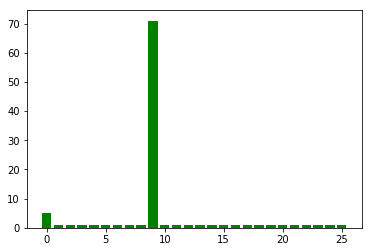

In [115]:
plt.bar(unique_labels , cluster_len_dict.values(), color='g')

In [117]:
Counter(cluster_len_dict.values())



Counter({5: 1, 1: 24, 71: 1})

In [118]:
cluster_len_dict.values()

dict_values([5, 1, 1, 1, 1, 1, 1, 1, 1, 71, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [249]:
x = 109

In [250]:
y = int(0.7*x)

In [251]:
z = x - y

In [252]:
a=int(z/2)
if z%2 == 0:
    b=int(z/2)
else:
    b=int(z/2)+1

In [253]:
y

76

In [254]:
a

16

In [255]:
b

17

In [256]:
y+a+b == x

True

In [ ]:
issparse(X)

In [240]:
# Later deal with the sets of size less than 3 aka 1 or 2: How to split them between training,testing,dev

In [34]:
from sklearn import *
from sklearn.metrics import hamming_loss
from sklearn.utils.multiclass import unique_labels

In [63]:
y_true_batch  = [[0,0,0,0],[1,0,0,1]]
x_batch       = [[1,1,0,0],[]]

y_true_batch = np.array(y_true_batch)
x_batch      = np.array(x_batch)

In [64]:
curr_hamming_loss = hamming_loss(y_true_batch, x_batch)

In [65]:
curr_hamming_loss 

0.5

In [72]:
def _weighted_sum(sample_score, sample_weight, normalize=False):
    if normalize:
        return np.average(sample_score, weights=sample_weight)
    elif sample_weight is not None:
        return np.dot(sample_score, sample_weight)
    else:
        return sample_score.sum()

In [75]:
_weighted_sum(y_true_batch != x_batch, None, normalize=True)

0.5

In [77]:
from scipy import sparse

In [79]:
sparse.issparse(y_true_batch )

False

In [84]:
np.append([[1, 2, 3], [4, 5, 6]], [[7, 8, 9]], axis=0)

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [95]:
x.append([1,3])

In [96]:
x

[[1, 3]]

In [93]:
x

[[1]]

In [89]:
print(x)

None
